In [2]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
from numpy import typing as npt

class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

        #q learning parameters
        self.alpha = 0.1 #learning rate
        self.gamma = 0.99  #discount
        self.q_table = dict()  #initial empty library

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)
    
    # Adding these for the q-learing 
    def choose_action(self, state):
        state_str = f'{state}'
        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(self.num_targets)  
        return np.argmax(self.q_table[state_str]) 

    def update_q_value(self, state, action, reward, next_state):
        state_str = f'{state}'
        next_state_str = f'{next_state}'

        if next_state_str not in self.q_table:
            self.q_table[next_state_str] = np.zeros(self.num_targets)

        best_next_action = np.argmax(self.q_table[next_state_str]) 
        td_error = reward + self.gamma * self.q_table[next_state_str][best_next_action] - self.q_table[state_str][action]

        self.q_table[state_str][action] += self.alpha * td_error


In [3]:
def main():
    """Main function."""
    num_targets = 10
    #if you want to change the parameters like the learning rate or discount factoer they are in the class 
    env = ModTSP(num_targets)
    num_episodes = 5000
    ep_rets = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        rewardperep = 0

        for _ in range(100):
            action = env.choose_action(state)  # You need to replace this with your algorithm that predicts the action.
            
            obs_, reward, terminated, truncated, info = env.step(action)
            env.update_q_value(state, action, reward, obs_)
            done = terminated or truncated
            rewardperep += reward
            state = obs_

            if done:
                break

        ep_rets.append(rewardperep)
        print(f"Episode {ep} : {rewardperep}")

    print(np.mean(ep_rets))
    return ep_rets

In [4]:
reward_list = main()

Episode 0 : -79977.52570343018
Episode 1 : -79927.52570343018
Episode 2 : -79927.52570343018
Episode 3 : -69865.94783782959
Episode 4 : -69865.94783782959
Episode 5 : -79917.52570343018
Episode 6 : -69855.94783782959
Episode 7 : -69855.94783782959
Episode 8 : -59785.12351226807
Episode 9 : -59785.12351226807
Episode 10 : -79957.52570343018
Episode 11 : -69915.94783782959
Episode 12 : -69915.94783782959
Episode 13 : -59845.12351226807
Episode 14 : -59845.12351226807
Episode 15 : -59845.12351226807
Episode 16 : -49852.78287601471
Episode 17 : -49855.95373916626
Episode 18 : -49809.50133514404
Episode 19 : -49809.50133514404
Episode 20 : -49809.50133514404
Episode 21 : -49809.50133514404
Episode 22 : -39832.08491516113
Episode 23 : -39850.53542327881
Episode 24 : -39793.64807033539
Episode 25 : -39793.64807033539
Episode 26 : -39793.64807033539
Episode 27 : -39793.64807033539
Episode 28 : -29827.86918926239
Episode 29 : -29839.837752342224
Episode 30 : -39793.64807033539
Episode 31 : -298

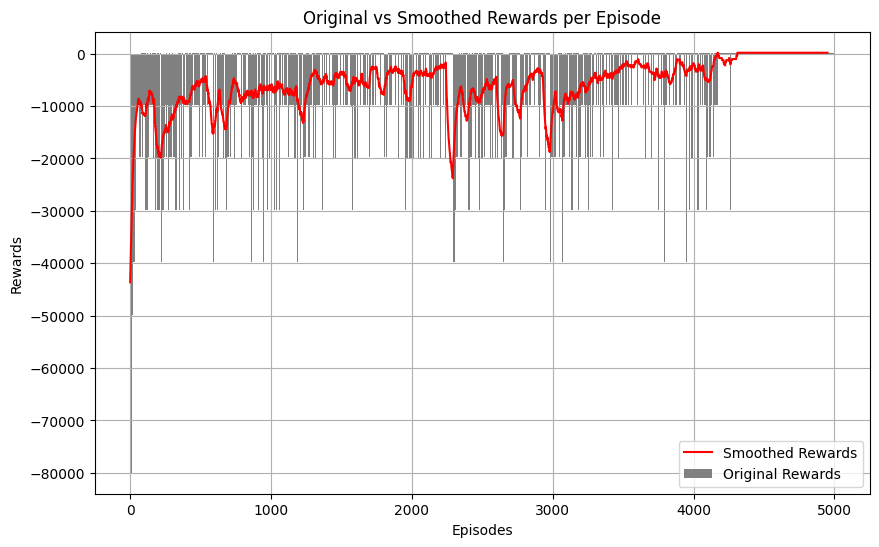

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_rewards(rewards, window_size=5):
    cumsum_vec = np.cumsum(np.insert(rewards, 0, 0)) 
    smoothed_rewards = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return smoothed_rewards

window_size = 50  
smoothed_rewards = smooth_rewards(reward_list, window_size)

episodes = np.arange(1, len(reward_list) + 1)
smoothed_episodes = np.arange(1, len(smoothed_rewards) + 1)

plt.figure(figsize=(10, 6))
plt.bar(episodes, reward_list, label='Original Rewards', color='grey', width = 2)
plt.plot(smoothed_episodes, smoothed_rewards, label='Smoothed Rewards', color='red', linestyle='-')

plt.title('Original vs Smoothed Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)
plt.show()
